In [1]:
# Nathan Tibbetts
# Lab 7 - Improved Wasserstein Generative Adversarial Network

%matplotlib notebook

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from os import listdir
from os.path import isfile, join

from skimage.io import imsave
from IPython.display import display, Image
import PIL.Image as PILImage

# Load Data:
# Note: Unsupervised, so no split between test and train.
TRAIN_DIR = "img_align_celeba"
train_files  = listdir(TRAIN_DIR)

N = len(train_files) # Number of images to use from the set.
S = 64   # Mini-batch size - shared for both train and test.
if (S > N): S = N

example = imread(join(TRAIN_DIR, train_files[0]))
RiH, RiW, C = example.shape
W = 32 # Resolution to reduce to before starting
H = W # int(W/float(RiW)*RiH)
IN_SHAPE  = (H, W, C) # Used only to scale down the images we work with
BATCH_IN_SHAPE  = (None, H, W, C)

#print "Accuracy Baseline is: %f" % ((len(train_pos)/float(len(train_in_files)) * len(test_pos) +
#                                    len(train_neg)/float(len(train_in_files)) * len(test_neg)) / len(test_in_files))
#     % we say pos. * num real pos. cases + % we say neg. * num real neg. cases, all / by num. cases to make a %.

#plt.imshow(example)
#plt.imshow(np.array(np.uint8(resize(example,IN_SHAPE)*255)))
#plt.imshow(np.array(resize(example,IN_SHAPE), dtype='float32'))
#plt.imshow(resize(example,IN_SHAPE))
#plt.imshow(example[RiH/4:3*RiH/4,(RiW-RiH/2)/2:RiW-(RiW-RiH/2)/2])
#plt.imshow(resize(example[RiH/4:3*RiH/4,(RiW-RiH/2)/2:RiW-(RiW-RiH/2)/2],IN_SHAPE))

print("Loading Data...")                               # This part is for zooming in and squaring
features = np.array([resize(imread(join(TRAIN_DIR, f))[RiH/4:3*RiH/4,(RiW-RiH/2)/2:RiW-(RiW-RiH/2)/2], IN_SHAPE)
                     for f in train_files[:N]],  dtype='float32')

# Whiten our data - zero mean and unit standard deviation
features = (features - np.mean(features)) / np.std(features)
# features = np.transpose(np.reshape(features,(N,3,32,32)),axes=[0,2,3,1])
# features is (N, 1024, 1024, 3), or (batch_size, height, width, channels)
print("Data Loaded.")

plt.show()

Loading Data...


/home/nathantibbetts/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Data Loaded.


In [2]:
# Layer Defining helper functions

def leaky_relu(x, alpha=0.0):
    return tf.maximum(alpha*x, x)

# # Convolution Layer:
# def conv( x, filter_size=3, stride=2, num_filters=64, relu=False, alpha=0.0, name="conv" ):
#     with tf.variable_scope(name):
#         W = tf.get_variable(name + "_W",
#                             shape=(filter_size,
#                                    filter_size,
#                                    x.get_shape().as_list()[3],
#                                    num_filters),
#                             initializer=tf.contrib.layers.variance_scaling_initializer())
#         b = tf.get_variable(name + "_b",
#                             shape=num_filters,
#                             initializer=tf.contrib.layers.variance_scaling_initializer())
#         # Notice the input x will be one minibatch at a time,
#         #    but right now we're just building a computation graph!
#         if (stride >= 1): h = tf.nn.conv2d(x, W, [1,int(stride),int(stride),1], padding="SAME", name=name + "_h")
#         else: h = tf.layers.conv2d_transpose(x, W, filter_size, [int(1.0/stride),int(1.0/stride)],
#                                              padding="same", name=name + "_h") #THIS IS BROKEN BECAUSE FILTERS SHOULD BE AN INTEGER!
#         h = tf.nn.bias_add(h, b, name=name + "_h")
#         if relu:
#             h = tf.nn.relu(h, alpha)
#         return h

# # Fully-Connected Layer:
# def fc( x, out_size=1000, relu=False, alpha=0.0, name="fc" ):
#     with tf.variable_scope(name):
#         W = tf.get_variable(name + "_W",
#                             shape=(x.get_shape().as_list()[-1],out_size), #first non-batch dimension
#                             initializer=tf.contrib.layers.variance_scaling_initializer())
#         b = tf.get_variable(name + "_b",
#                             shape=(1,out_size),
#                             initializer=tf.contrib.layers.variance_scaling_initializer())
#         h = tf.matmul(x, W, name=name + "_h") + b #Assuming batch is 0th index, broadcast instead!
#         #h = tf.nn.bias_add(h, b, name="h")#(tf.reshape(h,[-1]), b, name="h")
#         if relu:
#             h = leaky_relu(h, alpha)
#         return h

In [20]:
#-------------------------------------------#
# Designing the Generator and Discriminator #
#-------------------------------------------#

# Hyper-Parameters:
d = 100 # Dimensionality of random gaussian vector z
c = 0.001 # Learning Rate
lam = 10 # up to 0.05
beta1 = 0.5
beta2 = 0.999
ncritic = 1
alpha = 0.0002
v = 2.0 # Variance initialization factor

batch_norm_decay = 0.9
batch_norm_epsilon = 1e-5

def generator(vec, reuse):
    with tf.variable_scope("G_", reuse=reuse):
        G_h0 = tf.layers.dense(vec, 4*4*512, use_bias=True, name="fc0",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,4*4*512]
        G_h0 = tf.reshape(G_h0, [-1,4,4,512]) #[?,4,4,512]

        G_h1 = tf.layers.conv2d_transpose(G_h0, 256, 3, strides=(2,2), padding="same", name="conv1",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,8,8,256]
        G_h1 = leaky_relu(G_h1, alpha)
        #G_h1 = tf.contrib.layers.batch_norm(G_h1) # NEED EXTRA IF STATEMENTS FOR SINGLE IMAGES!

        G_h2 = tf.layers.conv2d_transpose(G_h1, 128, 3, strides=(2,2), padding="same", name="conv2",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,16,16,128]
        G_h2 = leaky_relu(G_h2, alpha)
        #G_h2 = tf.contrib.layers.batch_norm(G_h2)

        G_h3 = tf.layers.conv2d_transpose(G_h2, 64,  3, strides=(2,2), padding="same", name="conv3",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,32,32,64]
        G_h3 = leaky_relu(G_h3, alpha)
        #G_h3 = tf.contrib.layers.batch_norm(G_h3)

        G_h4 = tf.layers.conv2d_transpose(G_h3, 3,  3, strides=(1,1), padding="same", name="conv4",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,32,32,3]

        G_out = tf.tanh(G_h4)
        #G_out = (tf.tanh(G_h4) + 1)/2
        #G_out = tf.maximum(0.0,tf.minimum(1.0,G_h4))
        return G_out
    
def discriminator(images, reuse):
    with tf.variable_scope("D_", reuse=reuse):
        D_h0 = tf.layers.conv2d(images, 64, 3, strides=(2,2), padding="same", name="conv0",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,16,16,64]
        D_h0 = leaky_relu(D_h0, alpha)

        D_h1 = tf.layers.conv2d(D_h0, 128, 3, strides=(2,2), padding="same", name="conv1",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,8,8,128]
        D_h1 = leaky_relu(D_h1, alpha)
        #D_h1 = tf.contrib.layers.batch_norm(D_h1)

        D_h2 = tf.layers.conv2d(D_h1, 256, 3, strides=(2,2), padding="same", name="conv2",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,4,4,256]
        D_h2 = leaky_relu(D_h2, alpha)
        #D_h2 = tf.contrib.layers.batch_norm(D_h2)

        D_h3 = tf.layers.conv2d(D_h2, 256, 3, strides=(2,2), padding="same", name="conv3",
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v),
            bias_initializer=tf.contrib.layers.variance_scaling_initializer(factor=v))#[?,2,2,512]

        D_out = tf.reduce_mean(D_h3,axis=range(len(D_h3.get_shape()))[1:])#[?,]
        return D_out

In [21]:
#----------------------------------#
# Setting up the Computation Graph #
#----------------------------------#

tf.reset_default_graph()

z = tf.placeholder(dtype=tf.float32, shape=(None,d), name='z') # to sample: np.random.normal(d)
fake_images = generator(z,reuse=False)
true_images = tf.placeholder(dtype=tf.float32, shape=BATCH_IN_SHAPE, name='x')
#with tf.name_scope("x_hat"):
btwn_images = (fake_images + true_images)/2

fake_score = discriminator(fake_images, reuse=False)
true_score = discriminator(true_images, reuse=True)
btwn_score = discriminator(btwn_images, reuse=True)

#with tf.name_scope("D_loss"):
punishment = lam * (tf.norm(tf.gradients(btwn_score,btwn_images)) - 1)**2 # How close real images are to fake ones?
D_loss = tf.reduce_mean(fake_score - true_score + punishment)
#with tf.name_scope("G_loss"):
G_loss = -tf.reduce_mean(fake_score)
    
# Training Optimizers:
t_vars = tf.trainable_variables()
G_vars = [var for var in t_vars if 'G_' in var.name]
D_vars = [var for var in t_vars if 'D_' in var.name]
train_D = tf.train.AdamOptimizer(learning_rate=c, name='adam_D', beta1=beta1, beta2=beta2).minimize(D_loss)
train_G = tf.train.AdamOptimizer(learning_rate=c, name='adam_G', beta1=beta1, beta2=beta2).minimize(G_loss)

"""
# Summaries:
with tf.variable_scope("train_summary"):
    tf.summary.scalar('xent_loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    train_merged = tf.summary.merge_all()

with tf.variable_scope("test_summary"):
    tf.summary.scalar('xent_loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    test_merged = tf.summary.merge_all()
"""

'\n# Summaries:\nwith tf.variable_scope("train_summary"):\n    tf.summary.scalar(\'xent_loss\', loss)\n    tf.summary.scalar(\'accuracy\', accuracy)\n    train_merged = tf.summary.merge_all()\n\nwith tf.variable_scope("test_summary"):\n    tf.summary.scalar(\'xent_loss\', loss)\n    tf.summary.scalar(\'accuracy\', accuracy)\n    test_merged = tf.summary.merge_all()\n'

In [26]:
#----------#
# Training #
#----------#

num_batches = 6000
print_after = 120

z_test = np.random.normal(size=(1,d))
progress = [] #progressive development of a single z input

#For interpolation:
z1 = np.random.normal(size=d)
z2 = np.random.normal(size=d)
z10 = zip(*[np.linspace(z1[i],z2[i],10) for i in range(d)])

#-----------------------------------------------------------------------------------#
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)


0 	D_loss:  0.0494407574336 	G_loss:  -0.000458714055518
120 	D_loss:  5.00592753092 	G_loss:  -0.369114971161
240 	D_loss:  25.6238647461 	G_loss:  -1.44319648743
360 	D_loss:  61.2491129557 	G_loss:  -2.92786687215
480 	D_loss:  190.976660156 	G_loss:  -10.2302683512
600 	D_loss:  1374.9046875 	G_loss:  -37.0783528646
720 	D_loss:  6188.78333333 	G_loss:  -137.839615885
840 	D_loss:  4857774.93333 	G_loss:  -2455.14739583
960 	D_loss:  11979872.0 	G_loss:  -6131.64895833
1080 	D_loss:  27824635.7333 	G_loss:  -10394.76875
1200 	D_loss:  75899648.0 	G_loss:  -18438.21875
1320 	D_loss:  282676411.733 	G_loss:  -34332.3291667
1440 	D_loss:  1042359227.73 	G_loss:  -69077.275
1560 	D_loss:  1980299400.53 	G_loss:  -101143.366667
1680 	D_loss:  3134567219.2 	G_loss:  -141714.166667
1800 	D_loss:  5112291874.13 	G_loss:  -163212.066667
1920 	D_loss:  4839600947.2 	G_loss:  -185983.833333
2040 	D_loss:  7119763319.47 	G_loss:  -238499.066667
2160 	D_loss:  12095658393.6 	G_loss:  -314692.8


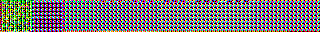

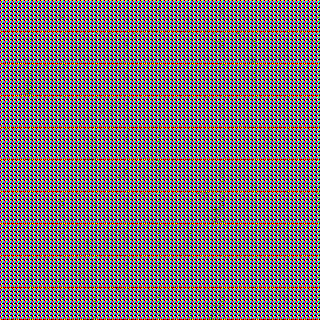

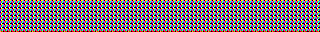

In [27]:
for t in xrange(num_batches):#(N/S):
#for t in np.ones(num_batches,dtype=np.int32): # Overfitting test
    d_avg = 0
    g_avg = 0
    z_in = np.random.normal(size=(S,d))
    x_indeces = np.random.randint(N,size=S)
    _, _, d_loss, g_loss = sess.run([train_D, train_G, D_loss, G_loss],
        feed_dict={true_images:features[x_indeces], z:z_in})
    #train_writer.add_summary(graph_summary, t)
    d_avg += d_loss
    g_avg += g_loss
    if t % print_after == 0:
        print t, "\tD_loss: ", d_avg/print_after, "\tG_loss: ", g_avg/print_after
        #print t, "\tD_loss: ", d_loss, "\tG_loss: ", g_loss
        d_avg = 0
        g_avg = 0
    if t % (num_batches/10) == 0:
        img = sess.run(fake_images, feed_dict={z:z_test})
        progress.append(img[0])

#train_writer.close()

# Build Progressive Strip:
progression = np.concatenate(progress,axis=1)
progression = np.maximum(0.0,np.minimum(1.0,progression))
progression = np.uint8(progression*255)

# Bulid Examples Multi-Image:
examples = sess.run(fake_images, feed_dict={z:np.random.normal(size=(100,d))})
im10 = np.concatenate([examples[range(i,i+10)] for i in range(0,100,10)],axis=1)
im100 = np.concatenate(im10,axis=1)
im100 = np.maximum(0.0,np.minimum(1.0,im100))
im100 = np.uint8(im100*255)

# Build Interpolation:
interpoles = sess.run(fake_images, feed_dict={z:z10})
interpolated = np.concatenate(interpoles,axis=1)
interpolated = np.maximum(0.0,np.minimum(1.0,interpolated))
interpolated = np.uint8(interpolated*255)

imsave("progression.png",progression)
imsave("multi-image.png",im100)
imsave("interpolation.png",interpolated)

display(PILImage.open('progression.png'))
display(PILImage.open('multi-image.png'))
display(PILImage.open('interpolation.png'))

In [ ]:
# The first image is a progression of the same z-vector over the course of the training,
# the second is 100 random sample images from the fully-trained generator,
# and the third is an interpolation between two random z-vectors after training.